downlaod from fashion MNIST  
```
wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz
```
put them into data/fashion

In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import misc
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

/Users/tdual/anaconda2/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./data/fashion', one_hot=True)

Extracting ./data/fashion/train-images-idx3-ubyte.gz
Extracting ./data/fashion/train-labels-idx1-ubyte.gz
Extracting ./data/fashion/t10k-images-idx3-ubyte.gz
Extracting ./data/fashion/t10k-labels-idx1-ubyte.gz


In [3]:
str_labels = ['t_shirt_top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']

In [4]:
img, label = mnist.train.next_batch(10)

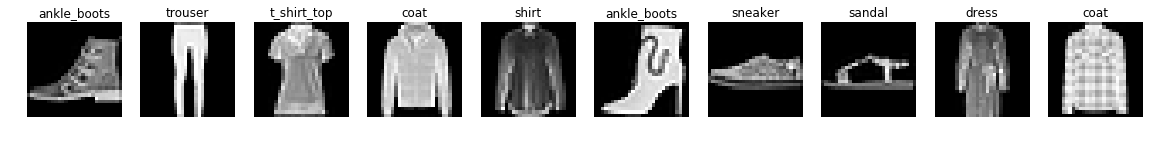

In [5]:
dim = 28

fig, axs = plt.subplots(1, len(img), figsize=(20, 3))

for i, (img, label )in enumerate(zip(img,label)):  
        axs[i].imshow(np.reshape(img, (dim, dim)),cmap='gray')
        axs[i].axis('off')
        axs[i].set_title(str_labels[np.argmax(label)])
plt.show()

In [6]:
def weight_variable(shape):
    w = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(w)


def bias_variable(shape):
    b = tf.constant(0.1, shape=shape)
    return tf.Variable(b)


def conv2d(x, filt, name):
    """
        x is a batch of images. x.shape is [batch_size, in_height, in_width, in_channels]
        filt is a filter. filt.shape is [filter_height, filter_width, in_channels, out_channels]
    """ 
    return tf.nn.conv2d(x, filt, strides=[1,1,1,1], padding='SAME', name=name)


def max_pool(x, name, size=2):
    """
        x is a batch of images. x.shape is [batch_size, in_height, in_width, in_channels]
        size is a pooling size using ksize.
        (ksize is a kernel size. ksize.shape is [batch_size, height, width, channels]
            The batch_size and channels are usual 1 on pooling. If you want 2x2 pooling, ksize=[1, 2, 2, 1])
    
    """
    return tf.nn.max_pool(x, ksize=[1, size, size, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)


def max_pool(x, name, size=2):
    """
        x is a batch of images. x.shape is [batch_size, in_height, in_width, in_channels]
        size is a pooling size using ksize.
        (ksize is a kernel size. ksize.shape is [batch_size, height, width, channels]
            The batch_size and channels are usual 1 on pooling. If you want 2x2 pooling, ksize=[1, 2, 2, 1])
    
    """
    return tf.nn.avg_pool(x, ksize=[1, size, size, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)


def conv_layer(x, out_size, name, filter_size=5, act="relu"):
    shape =x.get_shape().as_list()
    in_channel = shape[-1]
    with tf.name_scope("conv_{}".format(name)):
        with tf.name_scope('weights'):
            W = weight_variable([filter_size, filter_size, in_channel, out_size])
            variable_summaries(W)        
        with tf.name_scope('biases'):
            b = bias_variable([out_size])
            variable_summaries(b)
        h_conv = conv2d(x, W, "conv2d_{}".format(name))
        h = tf.nn.bias_add(h_conv, b)
        variable_summaries(h)
        
    if act == "relu":
        with tf.name_scope("conv_relu_{}".format(name)):
            h_act = tf.nn.relu(h)
    if act == "ident":
        h_act = h
    return h_act


def fc_layer(x_flatten, out_size, name, act="relu"):
    shape =x_flatten.get_shape().as_list()
    dim = shape[1]
    with tf.name_scope("fc_{}".format(name)):
        with tf.name_scope('weights'):
            W = weight_variable([dim, out_size])
        with tf.name_scope('biases'):   
            b  = bias_variable([out_size])
        h = tf.nn.bias_add(tf.matmul(x_flatten, W), b)
      
    if act == "relu":
        with tf.name_scope("fc_relu_{}".format(name)):
            h_act = tf.nn.relu(h)
    if act == "ident":
        h_act = h
    return h_act


def dropout(x, keep_prob, name):
    with tf.name_scope("dropout_{}".format(name)):
        h = tf.nn.dropout(x, keep_prob)
    return h
    

def flatten(x, name):
    shape = x.get_shape().as_list()
    dim = 1
    for s in shape[1:]:
        dim *= s
    with tf.name_scope(name):
        h = tf.reshape(x, [-1, dim])
    return h


def get_channel(x):
    shape = x.get_shape().as_list()
    return shape[-1]

def vgg_block(x, out_sizes, name):
    """
     x is a batch of images.
     out_sizes is a list of cnn layer sizes.
     name is this function's name. 
    """
    for idx, size in enumerate(out_sizes):
        if idx == 0:
            _x = x
        else:
            _x = h
        h = conv_layer(_x, size, "{}_{}".format(name, idx), filter_size=3)
        
    
    with tf.name_scope("pool_{}".format(name)):   
        h_pool1 = max_pool(h, name)
        variable_summaries(h_pool1)
    return h_pool1


def variable_summaries(var):  
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

In [7]:
input_shape = (28, 28, 1)  # original shape: (224, 224, 3)
height = input_shape(0)
width = input_shape(1)
in_channel = input_shape(2)
image_size = height * width
g1 = None

with tf.Graph().as_default() as g1:
    keep_prob = tf.placeholder(tf.float32)
    with tf.name_scope('input'):
        x = tf.placeholder(tf.float32, shape=[None, image_size], name='x-input')
        y_ = tf.placeholder(tf.float32, shape=[None, 10], name='y-input')

    with tf.name_scope('input_reshape'):    
        x_image = tf.reshape(x, [-1, height, width, in_channel])
        tf.summary.image('input',  x_image, 10)

    h_pool1 = vgg_block(x_image, [32, 32], "1") # original size: 64
    h_pool2 = vgg_block(h_pool1, [64, 64], "2") # original size: 128
    h_pool3 = vgg_block(h_pool2, [128, 128, 128], "3") # original size: 256
    h_pool4 = vgg_block(h_pool3, [256, 256, 256], "4") # original size: 512
    h_pool5 = vgg_block(h_pool4, [256, 256, 256], "5") # original size: 512
    h_pool_flat = flatten(h_pool5, "pool_flat")
    h_fc1 = fc_layer(h_pool_flat, 1024, "1", act="relu") # original size: 4096
    h_fc1_drop = dropout(h_fc1, keep_prob, "fc1")
    h_fc2 = fc_layer(h_fc1_drop, 1024, "2", act="relu") # original size: 4096
    h_fc2_drop = dropout(h_fc2, keep_prob, "fc2")
    y_conv = fc_layer(h_fc2_drop , 10, "3", act="ident") # original size: 1000

    with tf.name_scope("loss"):
        loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
        tf.summary.scalar('cross_entropy', loss)

    with tf.name_scope("optimizer"):
        opt = tf.train.AdamOptimizer(1e-4).minimize(loss)

    with tf.name_scope("accuracy"):
        correct = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        tf.summary.scalar('accuracy', accuracy)

In [8]:
import tensorboard as tb 
tb.show_graph(g1)

In [ ]:
n_iter = 2000
batch_size = 100
log_dir= "logs"
if tf.gfile.Exists(log_dir):
    tf.gfile.DeleteRecursively(log_dir)
tf.gfile.MakeDirs(log_dir)



with tf.Session(graph=g1) as sess:
    sess.run(tf.global_variables_initializer())
    
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(log_dir + '/train', sess.graph)
    test_writer = tf.summary.FileWriter(log_dir + '/test')
    
    for i in tqdm(range(n_iter)):
        batch = mnist.train.next_batch(batch_size)
        _ = sess.run(opt, feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.6})
        
        if i % 100 == 0 and i != 0:
            train_loss, train_accuracy, summary = sess.run([loss, accuracy, merged], feed_dict={
                  x: batch[0], y_: batch[1], keep_prob: 0.7})
            print('step %d, training loss %g, training accuracy %g' % (i, train_loss, train_accuracy))
            train_writer.add_summary(summary, i)
        
    test_accuracy, test_summary, = sess.run([accuracy, merged], 
                                           feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0})
    test_writer.add_summary(test_summary, 0)
    print('test accuracy %g' % test_accuracy)

HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

step 100, training loss 11.9311, training accuracy 0.62
step 200, training loss 6.55958, training accuracy 0.73
step 300, training loss 8.14166, training accuracy 0.63
